In [552]:


import numpy as np 
import pandas as pd 

In [553]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks
import tensorflow as tf

np.random.seed(0)

In [554]:
data = pd.read_csv("weatherAUS.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [555]:
data.shape

(145460, 23)

**About the data:**

The dataset contains about 10 years of daily weather observations from different locations across Australia. Observations were drawn from numerous weather stations. 

In this project, I will use this data to predict whether or not it will rain the next day. There are 23 attributes including the target variable "RainTomorrow", indicating whether or not it will rain the next day or not. 

In [556]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

C:\Users\asus\AppData\Local\Temp\ipykernel_3224\3342335687.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x= data["RainTomorrow"], palette= cols)


<Axes: xlabel='RainTomorrow', ylabel='count'>

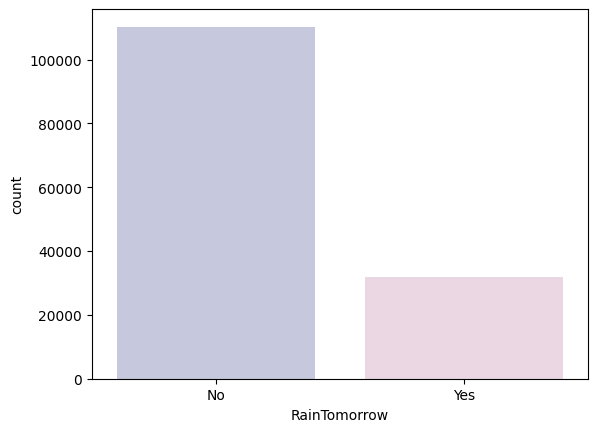

In [557]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
import seaborn as sns
cols= ["#C2C4E2","#EED4E5"]
sns.countplot(x= data["RainTomorrow"], palette= cols)

**Now I will parse Dates into datetime.**

My goal is to build an artificial neural network(ANN). I will encode dates appropriately, i.e. I prefer the months and days in a cyclic continuous feature. As, date and time are inherently cyclical. To let the ANN model know that a feature is cyclical I split it into periodic subsections. Namely, years, months and days. Now for each subsection, I create two new features, deriving a sine transform and cosine transform of the subsection feature. 

In [558]:
#Parsing datetime
#exploring the length of date objects
lengths = data["Date"].str.len()
lengths.value_counts()

Date
10    145460
Name: count, dtype: int64

In [559]:
#Continuity: These features ensure that the model understands the continuous and cyclical nature of the data.
#Distance Preservation: They help maintain the relative distances between cyclical values, which simple integer encoding cannot do.
#Improved Learning: Neural networks and other machine learning models can learn the underlying patterns in cyclical data more effectively with these encodings.
#nn ko btane ke liye december aur jan paas paas h aur 22:00 aur 00:00 paas paas h isliye krte h sin cos transform

In [560]:

data['Date']= pd.to_datetime(data["Date"])

data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters. 
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature. 

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


In [561]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

In [562]:
# roughly a year's span section 
section = data[:360] 
section["day"].values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
       30, 31,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14

Text(0.5, 0, 'Days In Year')

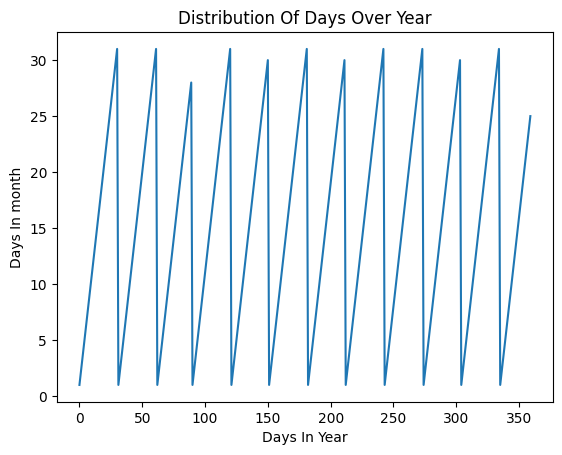

In [563]:
tm = section["day"].plot()
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")#kahi se tuta hua nhi h hmne series ke hr ek element ko plot karqa h dekha data continous h kahi se toota hua ni h

As expected, the "year" attribute of data repeats. However in this for the true cyclic nature is not presented in a continuous manner. Splitting months and days into Sine and cosine combination provides the cyclical continuous feature. This can be used as input features to ANN. 

Text(0.5, 0, 'Sine Encoded Months')

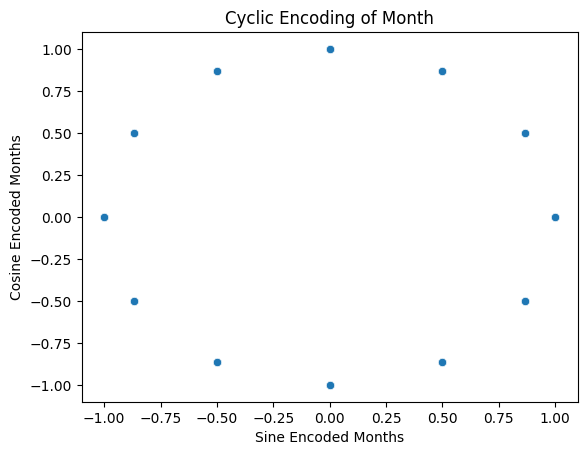

In [564]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data)
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")


Text(0.5, 0, 'Sine Encoded Day')

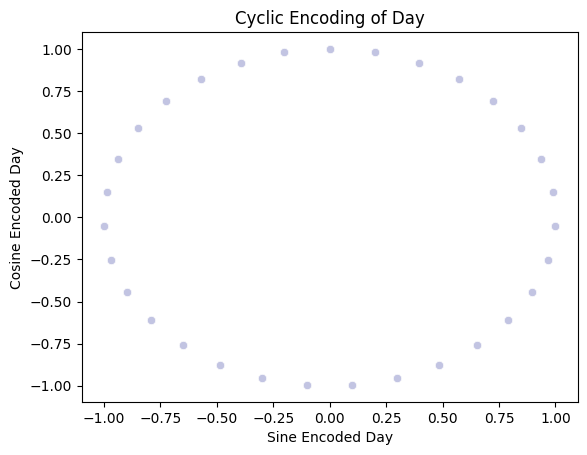

In [565]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

Next, I will deal with missing values in categorical and numeric attributes separately

**Categorical variables**

* Filling missing values with mode of the column value

In [566]:
object_cols = data.select_dtypes(include='object').columns
object_cols

Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday',
       'RainTomorrow'],
      dtype='object')

In [567]:
# Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [568]:
# Filling missing values with mode of the column in value

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

C:\Users\asus\AppData\Local\Temp\ipykernel_3224\1733177674.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(data[i].mode()[0], inplace=True)


**Numerical variables**

* Filling missing values with median of the column value

In [569]:
# Get list of neumeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


<Axes: >

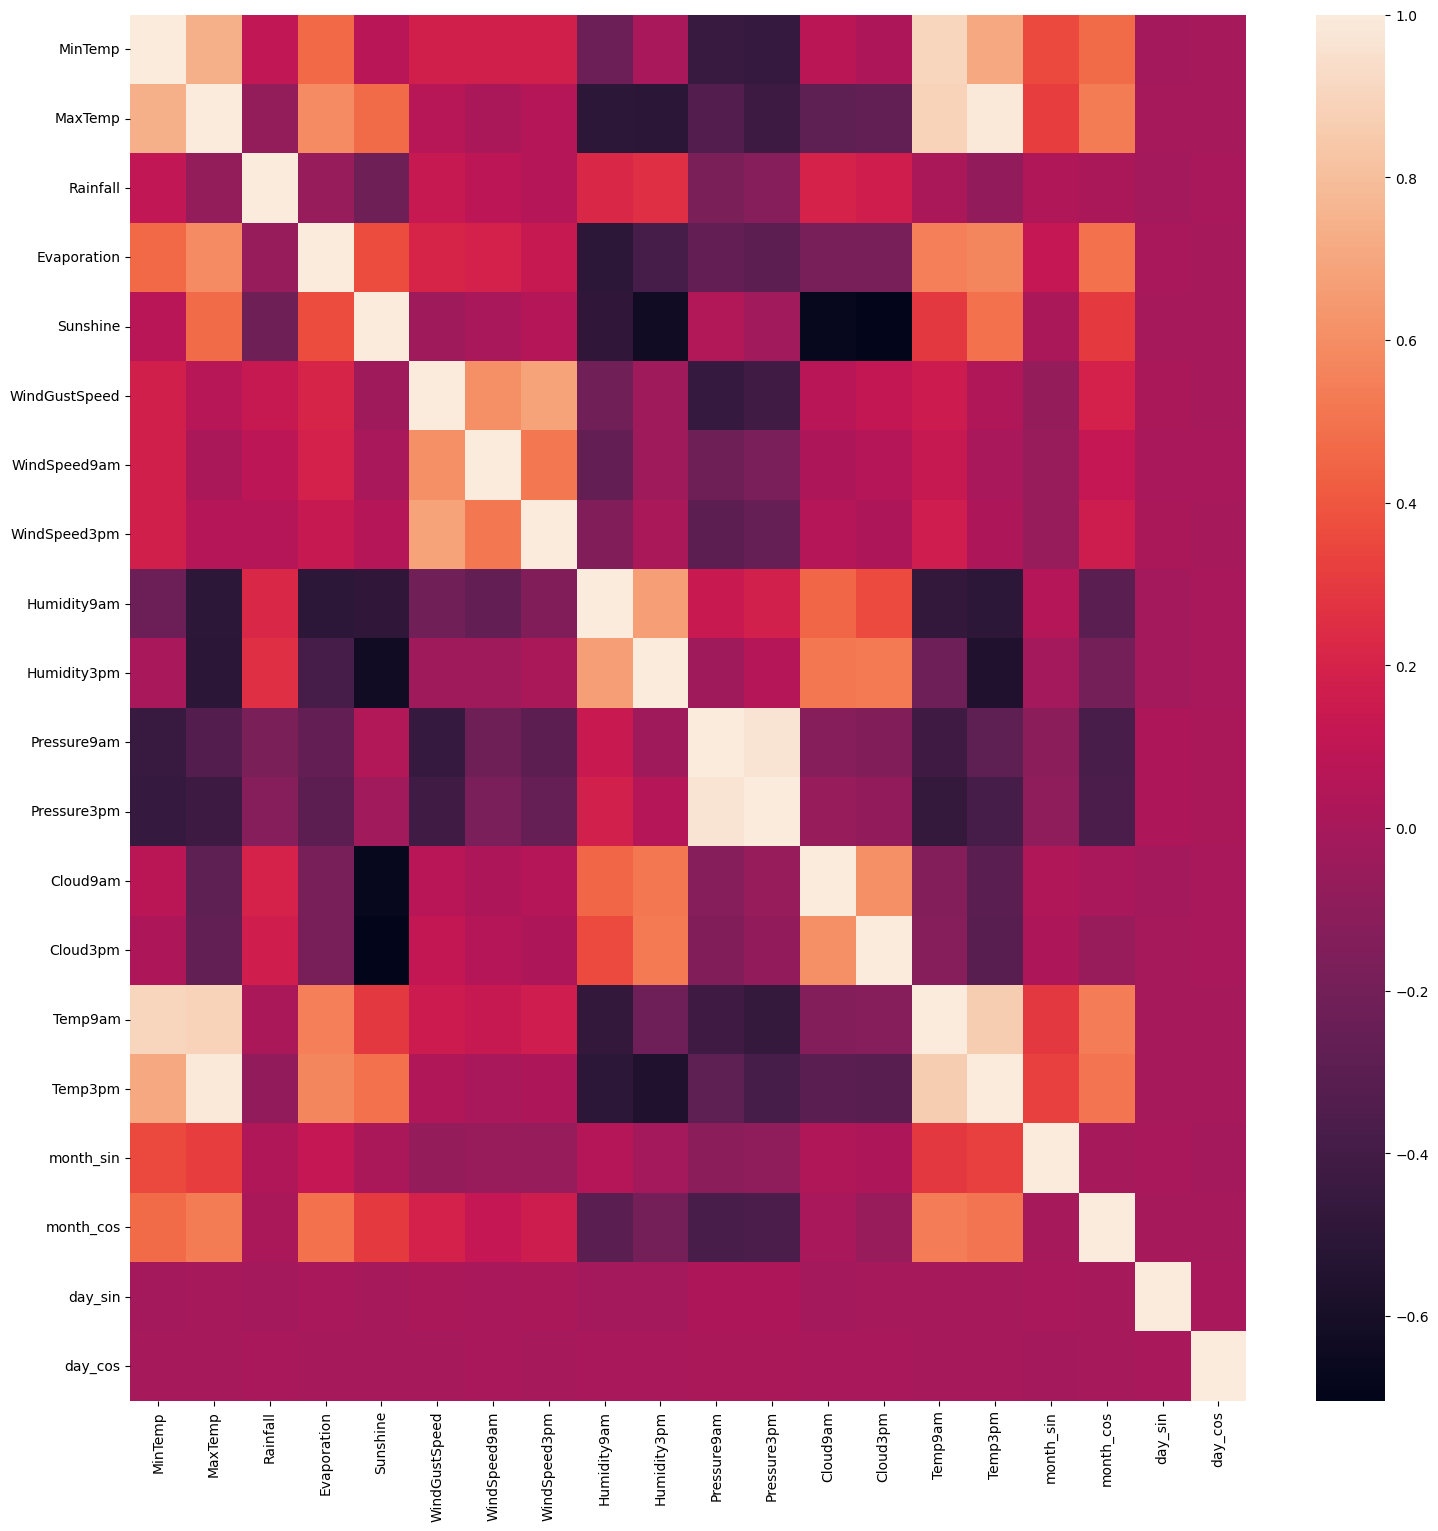

In [570]:

corrmat = data[num_cols].corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat)

In [571]:
data[num_cols].corr()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,month_sin,month_cos,day_sin,day_cos
MinTemp,1.000000,0.736555,0.103938,0.466993,0.072586,0.177415,0.175064,0.175173,-0.232899,0.006089,-0.450970,-0.461292,0.078754,0.021605,0.901821,0.708906,0.352035,0.472882,-0.005492,-0.001083
MaxTemp,0.736555,1.000000,-0.074992,0.587932,0.470156,0.067615,0.014450,0.050300,-0.504110,-0.508855,-0.332061,-0.427167,-0.289370,-0.277921,0.887210,0.984503,0.308538,0.530574,-0.002927,-0.005020
Rainfall,0.103938,-0.074992,1.000000,-0.064351,-0.227549,0.133659,0.087338,0.057887,0.224405,0.255755,-0.168154,-0.126534,0.198528,0.172403,0.011192,-0.079657,0.036673,0.008635,-0.006247,0.008030
Evaporation,0.466993,0.587932,-0.064351,1.000000,0.365602,0.203021,0.193084,0.129400,-0.504092,-0.390243,-0.270362,-0.293581,-0.183793,-0.182618,0.545115,0.572893,0.116950,0.490707,0.005430,-0.002054
Sunshine,0.072586,0.470156,-0.227549,0.365602,1.000000,-0.034750,0.005499,0.053834,-0.490819,-0.629130,0.041970,-0.019719,-0.675323,-0.703930,0.291188,0.490501,0.012630,0.298170,-0.002324,-0.004617
WindGustSpeed,0.177415,0.067615,0.133659,0.203021,-0.034750,1.000000,0.605303,0.686307,-0.215070,-0.026327,-0.458744,-0.413749,0.071736,0.109168,0.150150,0.032748,-0.066909,0.191619,0.008361,0.001497
WindSpeed9am,0.175064,0.014450,0.087338,0.193084,0.005499,0.605303,1.000000,0.519547,-0.270858,-0.031614,-0.228743,-0.175817,0.025112,0.054639,0.128545,0.004569,-0.054681,0.120590,0.008210,0.002020
WindSpeed3pm,0.175173,0.050300,0.057887,0.129400,0.053834,0.686307,0.519547,1.000000,-0.145525,0.016432,-0.296351,-0.255439,0.053337,0.025396,0.163030,0.027778,-0.063390,0.161000,0.010479,-0.000117
Humidity9am,-0.232899,-0.504110,0.224405,-0.504092,-0.490819,-0.215070,-0.270858,-0.145525,1.000000,0.666949,0.139442,0.186858,0.452297,0.357326,-0.471354,-0.498399,0.049713,-0.301770,-0.015178,0.004974
Humidity3pm,0.006089,-0.508855,0.255755,-0.390243,-0.629130,-0.026327,-0.031614,0.016432,0.666949,1.000000,-0.027544,0.051997,0.517120,0.523120,-0.221019,-0.557841,-0.007542,-0.194071,-0.014035,0.003426


In [572]:
#dekhte h as min aur max temp m multicolinearity dikh ri toh dono ho hatake avg temp bnade

In [573]:
# Missing values in numeric variables

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [574]:
# as mean+- sigma contains 67% of data points
# mean+-2sigma 97% so replacing all null values by random value between mean+-sigma will make our assumption a bit more accurate
import random
for i in num_cols:
    lowerlimit = data[i].mean() - data[i].std()
    upperlimit = data[i].mean() + data[i].std()
    n = data[i].isnull().sum()
    def random_value_in_range(lower, upper):
        return random.uniform(lower, upper+1)
    for _ in range(n):
        l = random_value_in_range(lowerlimit, upperlimit)
        data[i].fillna(l, inplace=True)

C:\Users\asus\AppData\Local\Temp\ipykernel_3224\4168023250.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(l, inplace=True)


In [575]:
data.sample()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
138175,2014-12-03,AliceSprings,21.9,39.4,1.6,11.2,11.5,NNW,57.0,NE,...,35.4,Yes,Yes,2014,12,-2.449294e-16,1.0,3,0.571268,0.820763


In [576]:
for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 0
MaxTemp 0
Rainfall 0
Evaporation 0
Sunshine 0
WindGustSpeed 0
WindSpeed9am 0
WindSpeed3pm 0
Humidity9am 0
Humidity3pm 0
Pressure9am 0
Pressure3pm 0
Cloud9am 0
Cloud3pm 0
Temp9am 0
Temp3pm 0
month_sin 0
month_cos 0
day_sin 0
day_cos 0


Text(0.5, 0, 'Years')

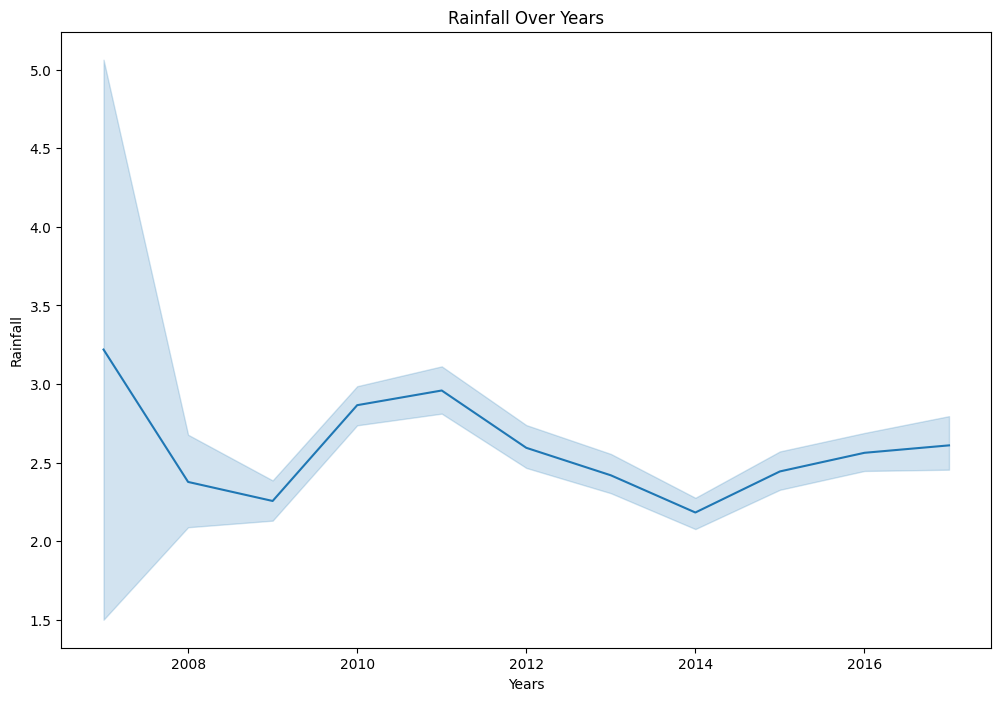

In [577]:
#plotting a lineplot rainfall over years
plt.figure(figsize=(12,8))
Time_series=sns.lineplot(x=data['year'],y=data["Rainfall"])
Time_series.set_title("Rainfall Over Years")
Time_series.set_ylabel("Rainfall")
Time_series.set_xlabel("Years")

In [578]:
data["WindGustSpeed"]

0         44.000000
1         44.000000
2         46.000000
3         24.000000
4         41.000000
            ...    
145455    31.000000
145456    22.000000
145457    37.000000
145458    28.000000
145459    51.418769
Name: WindGustSpeed, Length: 145460, dtype: float64

Text(0.5, 0, 'Year')

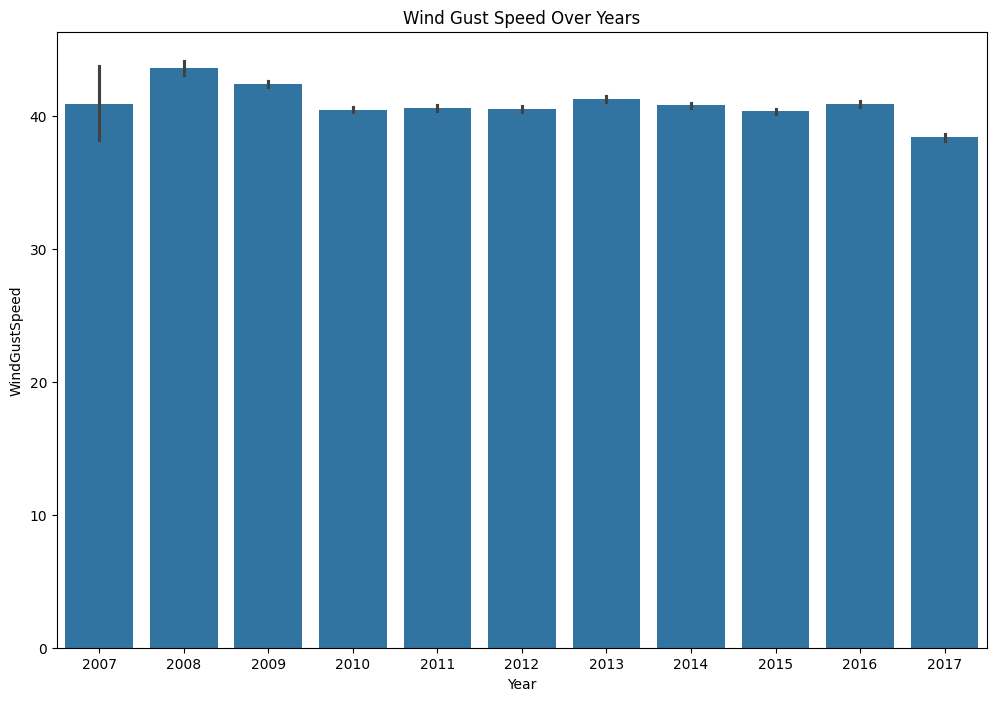

In [579]:

plt.figure(figsize=(12,8))
Days_of_week=sns.barplot(x=data['year'],y=data["WindGustSpeed"])
Days_of_week.set_title("Wind Gust Speed Over Years")
Days_of_week.set_ylabel("WindGustSpeed")
Days_of_week.set_xlabel("Year")

<Axes: xlabel='year', ylabel='WindGustSpeed'>

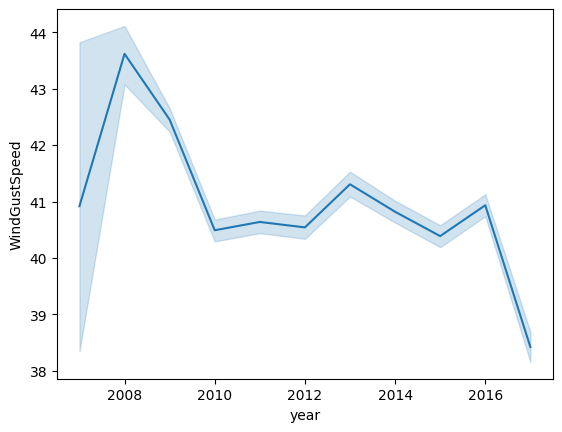

In [580]:
sns.lineplot(x=data['year'],y=data["WindGustSpeed"])

**Label encoding the catagorical varable**

In [581]:
# Prepairing attributes of scale data

features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']



In [582]:
features["Avg_temp"]=features["MinTemp"]+features["MaxTemp"]

In [583]:
features=features.drop(columns=["MinTemp","MaxTemp"])

In [584]:
features

,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,year,month_sin,month_cos,day_sin,day_cos,Avg_temp
0,Albury,0.6,9.449517,4.965421,W,44.000000,W,WNW,20.0,24.0,...,5.261108,16.9,21.8,No,2008,-2.449294e-16,1.0,0.201299,0.979530,36.300000
1,Albury,0.0,9.449517,4.965421,WNW,44.000000,NNW,WSW,4.0,22.0,...,5.261108,17.2,24.3,No,2008,-2.449294e-16,1.0,0.394356,0.918958,32.500000
2,Albury,0.0,9.449517,4.965421,WSW,46.000000,W,WSW,19.0,26.0,...,2.000000,21.0,23.2,No,2008,-2.449294e-16,1.0,0.571268,0.820763,38.600000
3,Albury,0.0,9.449517,4.965421,NE,24.000000,SE,E,11.0,9.0,...,5.261108,18.1,26.5,No,2008,-2.449294e-16,1.0,0.724793,0.688967,37.200000
4,Albury,1.0,9.449517,4.965421,W,41.000000,ENE,NW,7.0,20.0,...,8.000000,17.8,29.7,No,2008,-2.449294e-16,1.0,0.848644,0.528964,49.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,0.0,9.449517,4.965421,E,31.000000,SE,ENE,13.0,11.0,...,5.261108,10.1,22.4,No,2017,1.224647e-16,-1.0,-0.897805,-0.440394,26.200000
145456,Uluru,0.0,9.449517,4.965421,NNW,22.000000,SE,N,13.0,9.0,...,5.261108,10.9,24.5,No,2017,1.224647e-16,-1.0,-0.968077,-0.250653,28.900000
145457,Uluru,0.0,9.449517,4.965421,N,37.000000,SE,WNW,9.0,9.0,...,5.261108,12.5,26.1,No,2017,1.224647e-16,-1.0,-0.998717,-0.050649,32.300000
145458,Uluru,0.0,9.449517,4.965421,SE,28.000000,SSE,N,13.0,7.0,...,2.000000,15.1,26.0,No,2017,1.224647e-16,-1.0,-0.988468,0.151428,34.800000


In [585]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
Rainfall,145460.0,2.530701,8.457133,0.000000,0.000000,0.000000e+00,1.000000,371.000000
Evaporation,145460.0,7.186813,3.726125,0.000000,4.000000,9.449517e+00,9.449517,145.000000
Sunshine,145460.0,6.340956,3.032711,0.000000,4.965421,4.965421e+00,8.700000,14.500000
WindGustSpeed,145460.0,40.838401,13.438246,6.000000,31.000000,3.900000e+01,50.000000,135.000000
WindSpeed9am,145460.0,13.974302,8.882957,0.000000,7.000000,1.300000e+01,19.000000,130.000000
WindSpeed3pm,145460.0,18.649695,8.717029,0.000000,13.000000,1.804689e+01,24.000000,87.000000
Humidity9am,145460.0,68.892058,18.854945,0.000000,57.000000,6.949613e+01,83.000000,100.000000
Humidity3pm,145460.0,51.298388,20.515408,0.000000,37.000000,5.100000e+01,65.000000,100.000000
Pressure9am,145460.0,1017.182845,6.867366,980.500000,1013.139910,1.016600e+03,1021.800000,1041.000000
Pressure3pm,145460.0,1016.024249,7.037940,977.100000,1011.100000,1.016200e+03,1022.200000,1039.600000


C:\Users\asus\AppData\Local\Temp\ipykernel_3224\2524434445.py:5: UserWarning: 
The palette list has fewer values (5) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)#boxenplot h


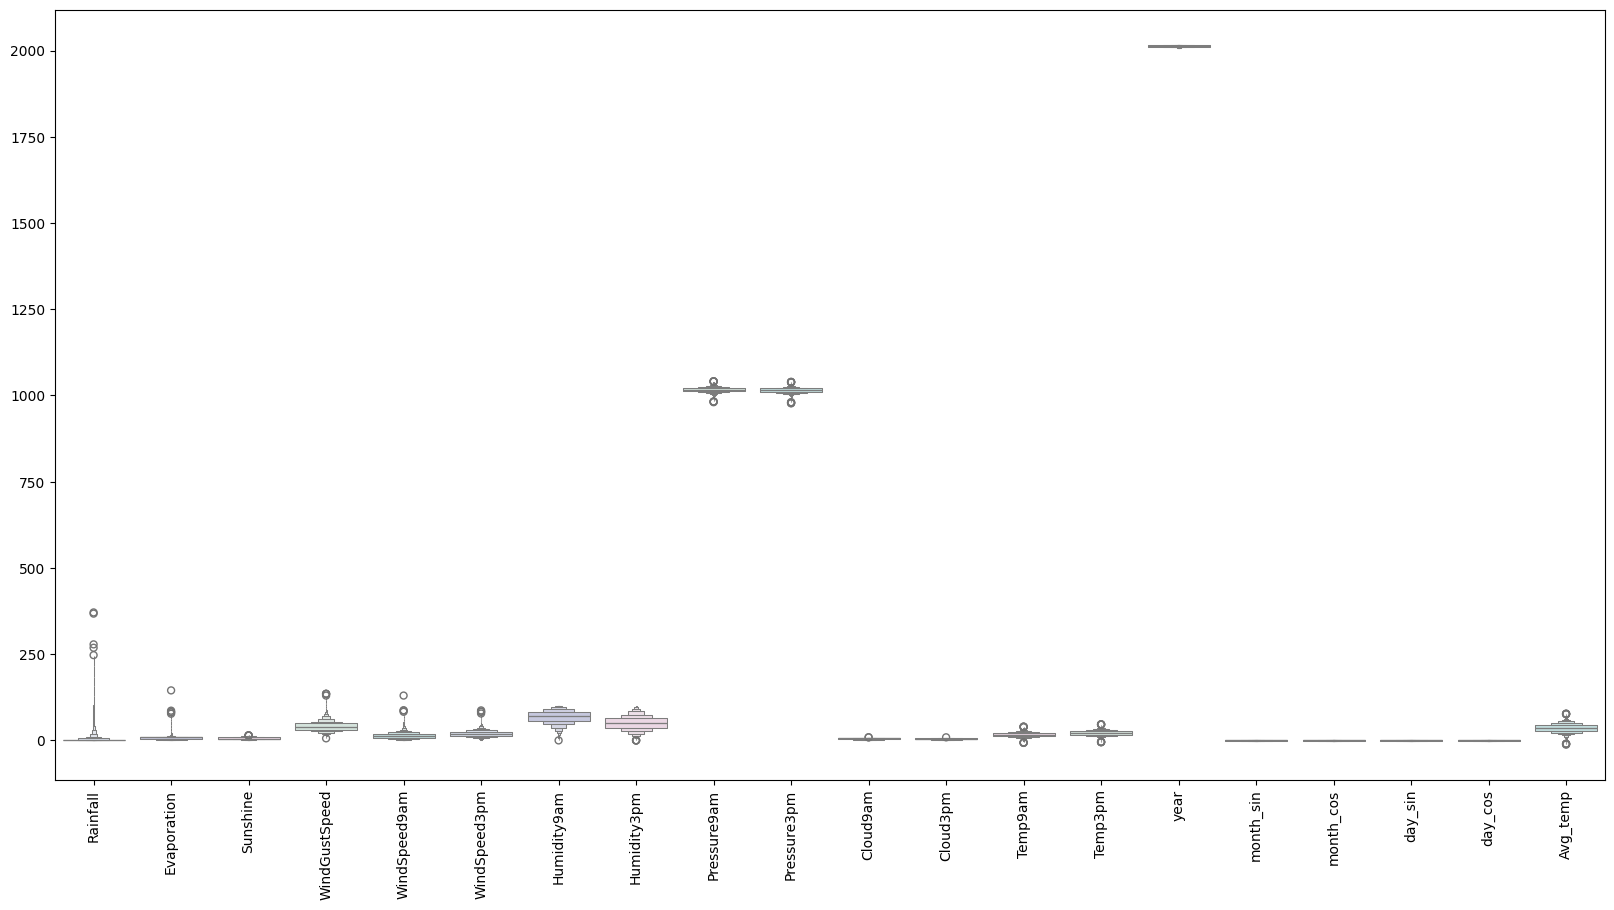

In [586]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)#boxenplot h 
plt.xticks(rotation=90)#taaki x label vertical dekhe
plt.show()

In [587]:
features["RainTomorrow"] = target

In [588]:
col_to_modify=["Avg_temp","Rainfall","Evaporation","Sunshine","WindGustSpeed","WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm","Pressure9am","Pressure3pm","Cloud9am","Cloud3pm","Temp9am","Temp3pm"]

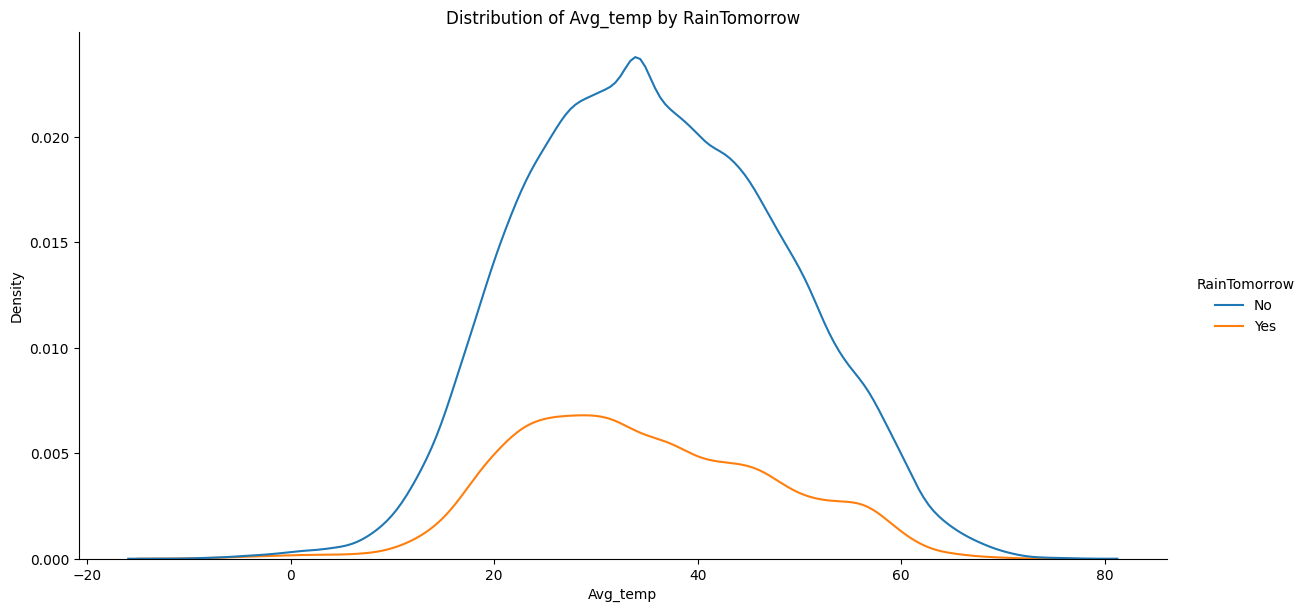

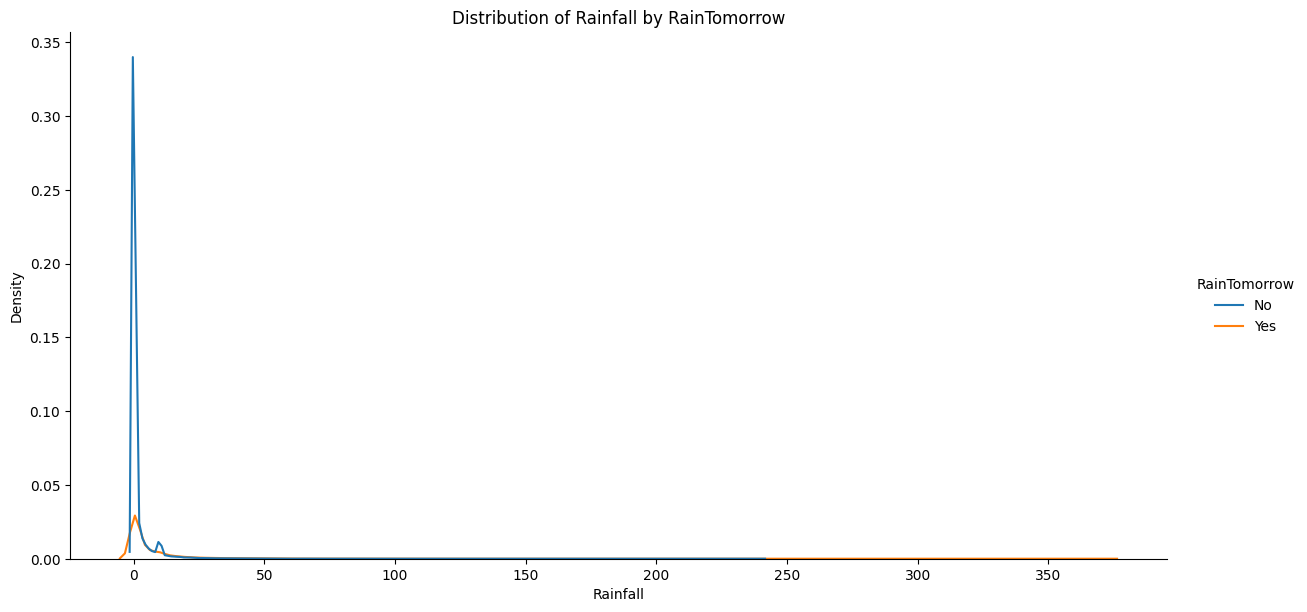

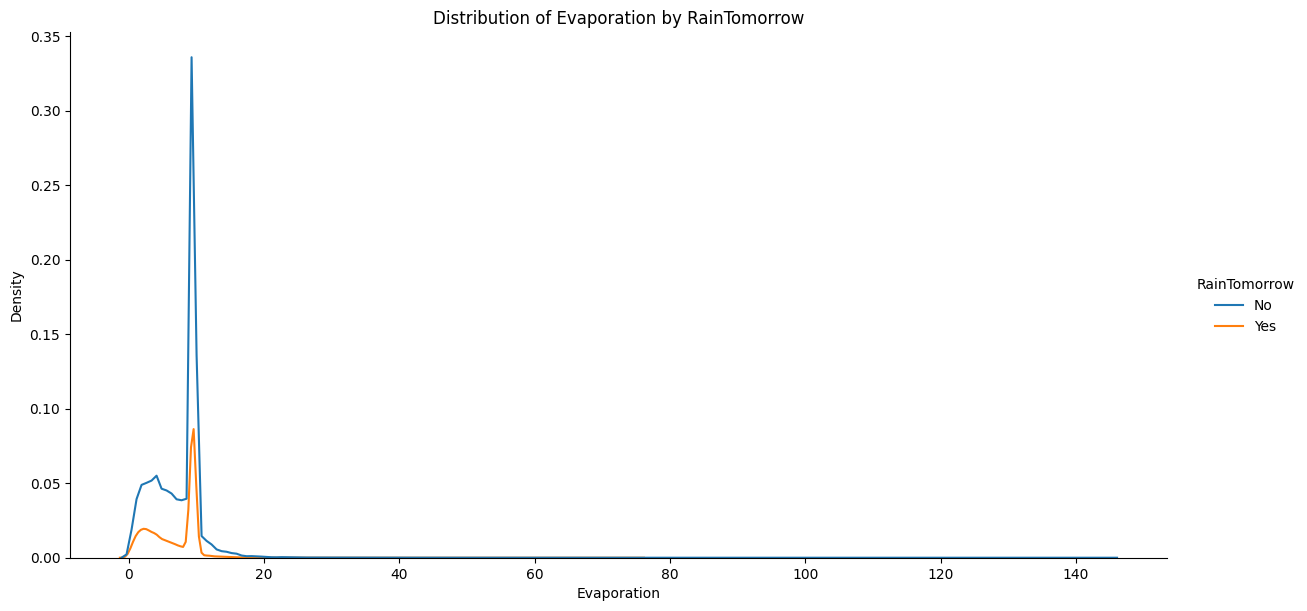

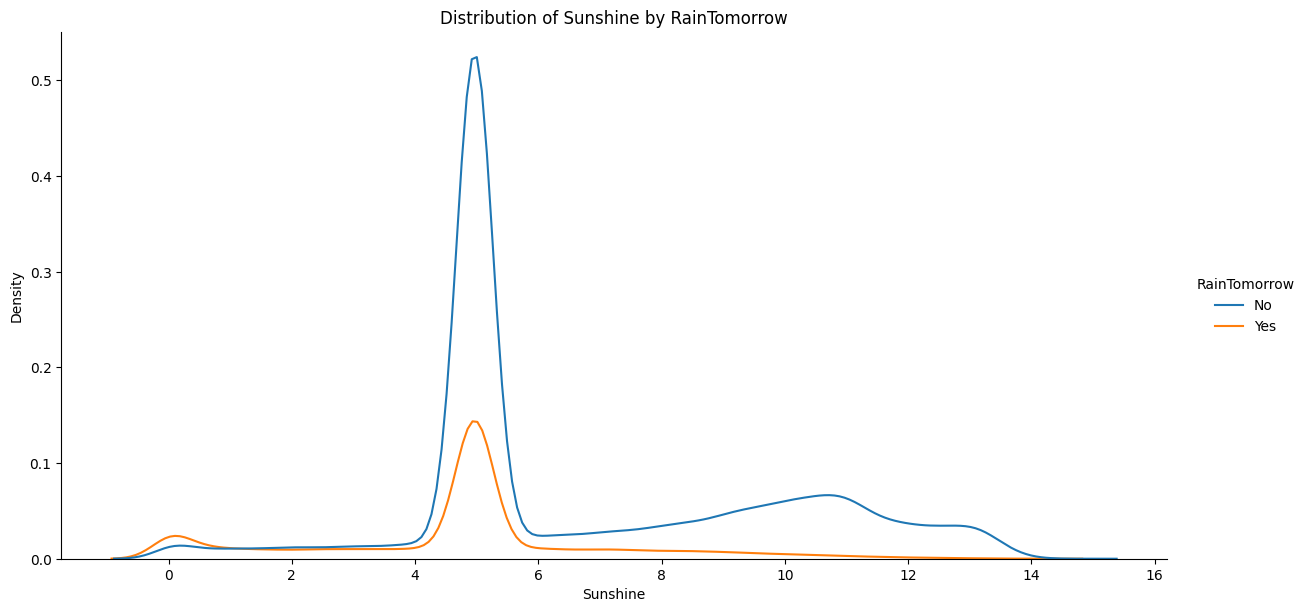

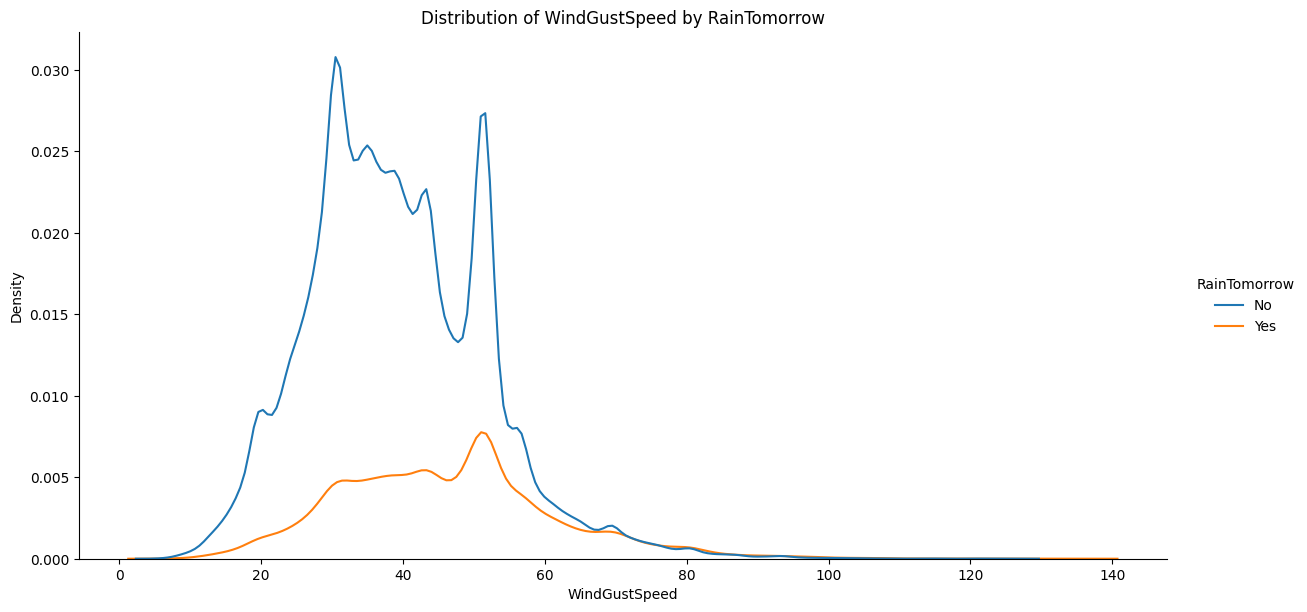

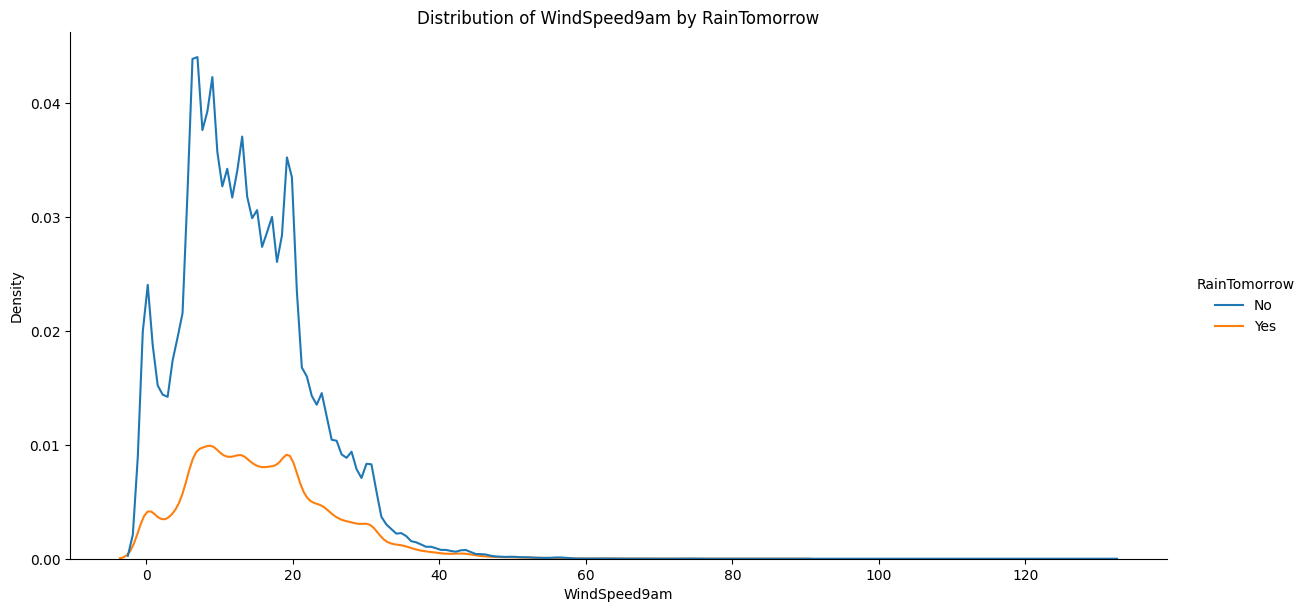

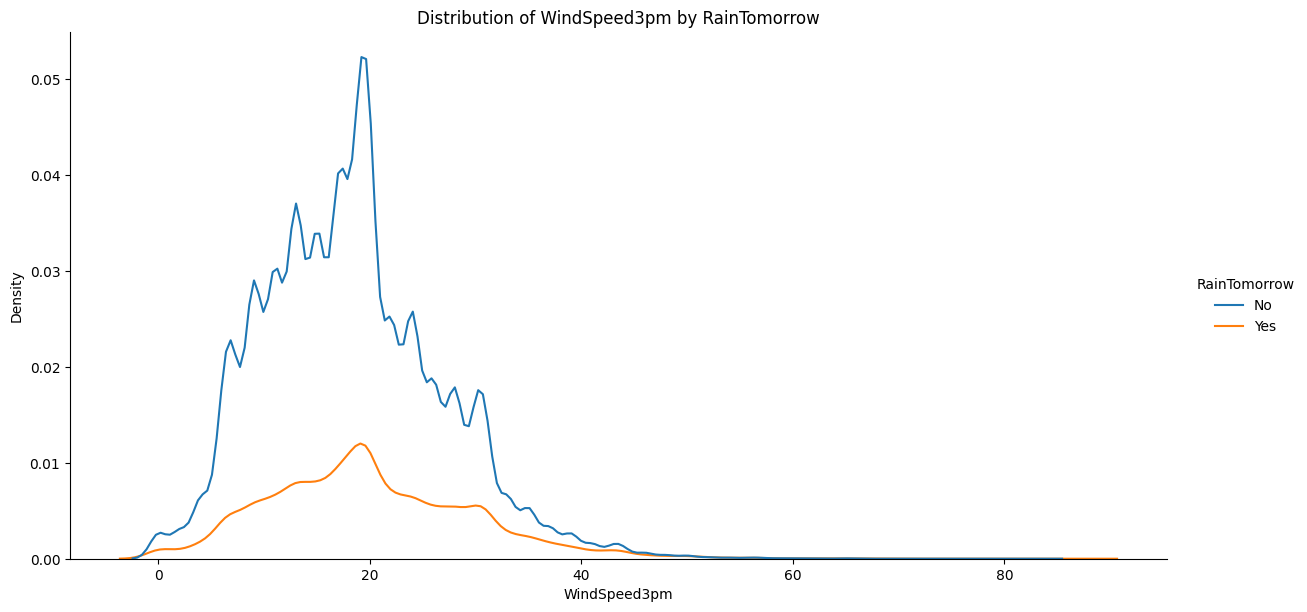

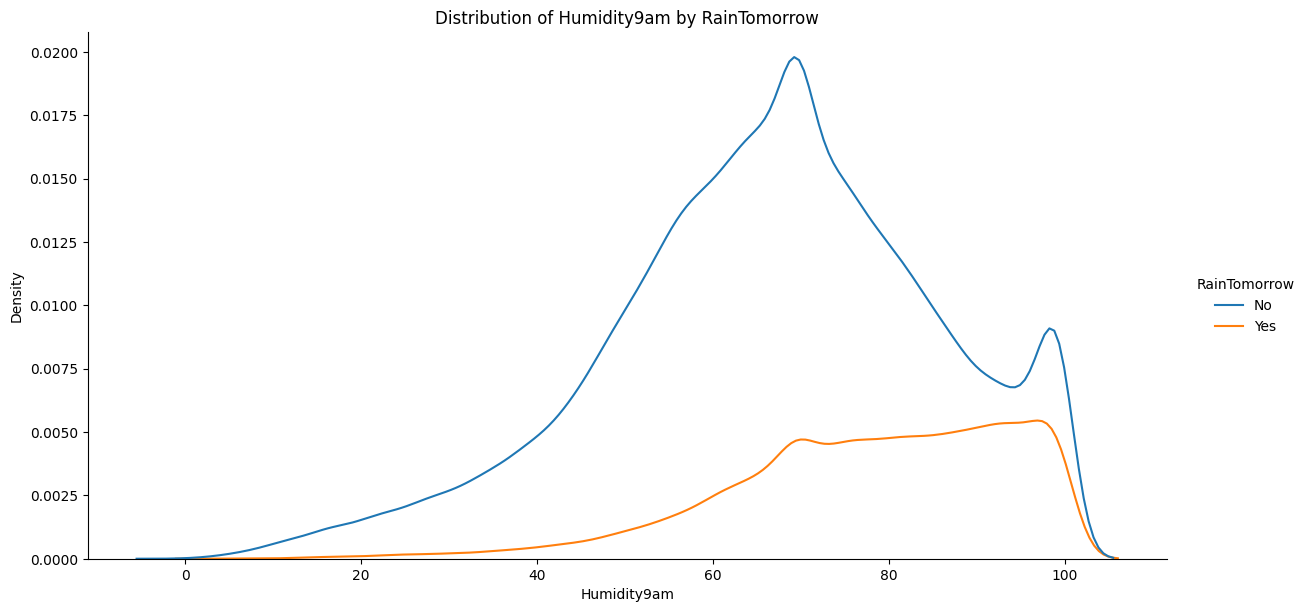

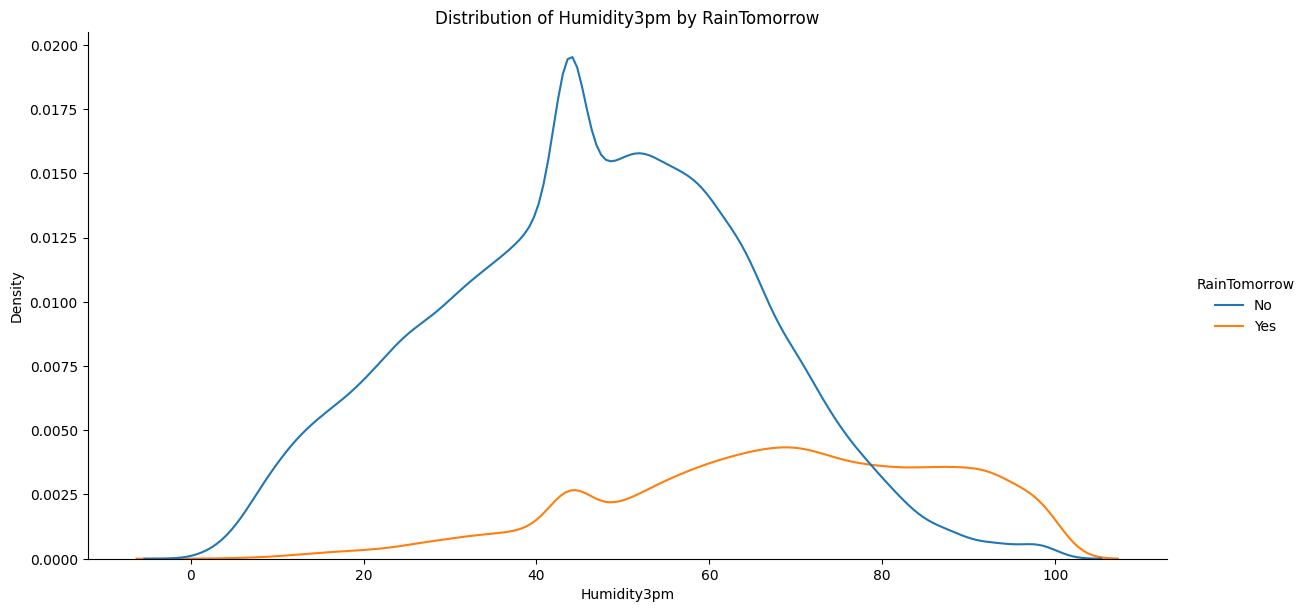

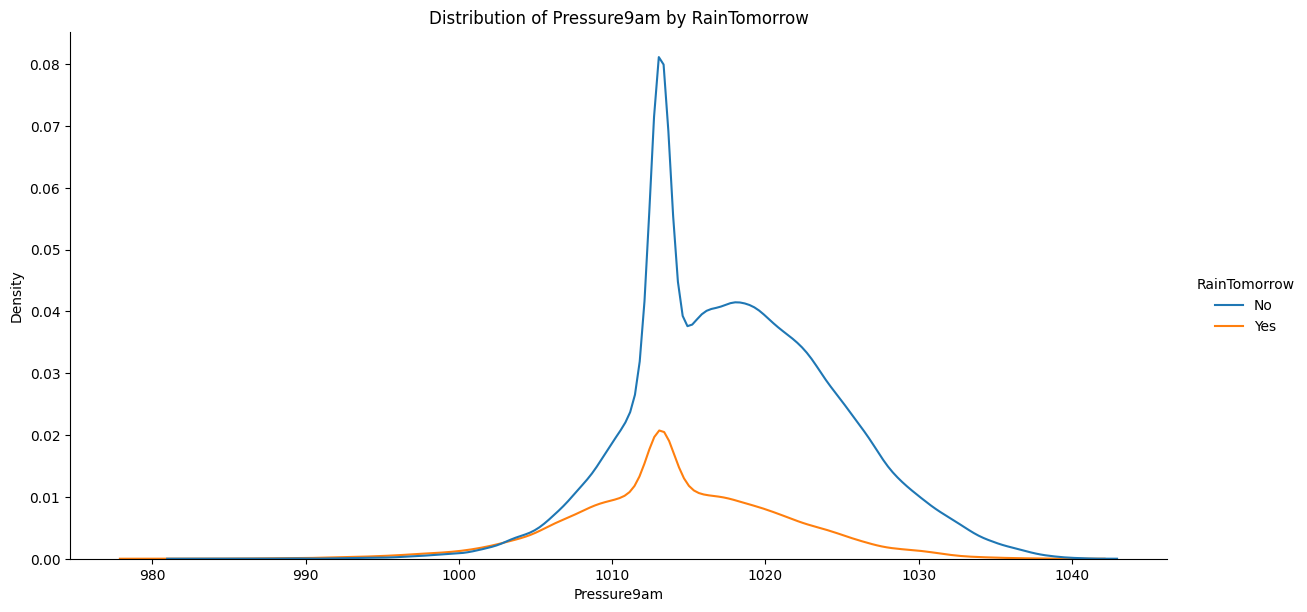

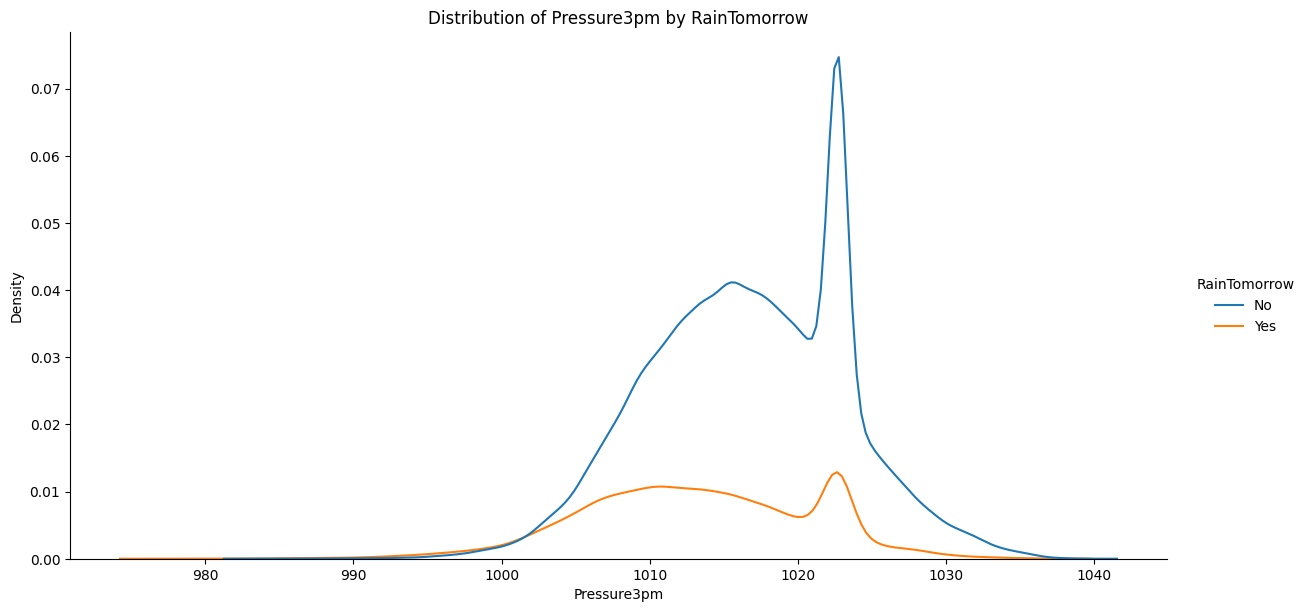

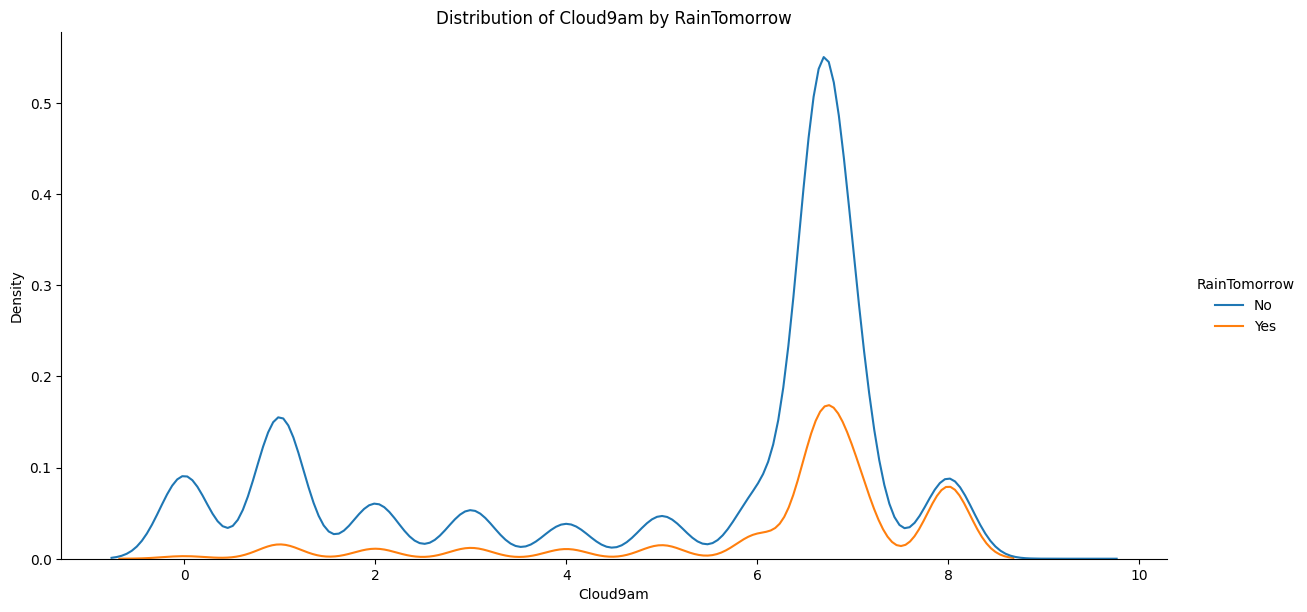

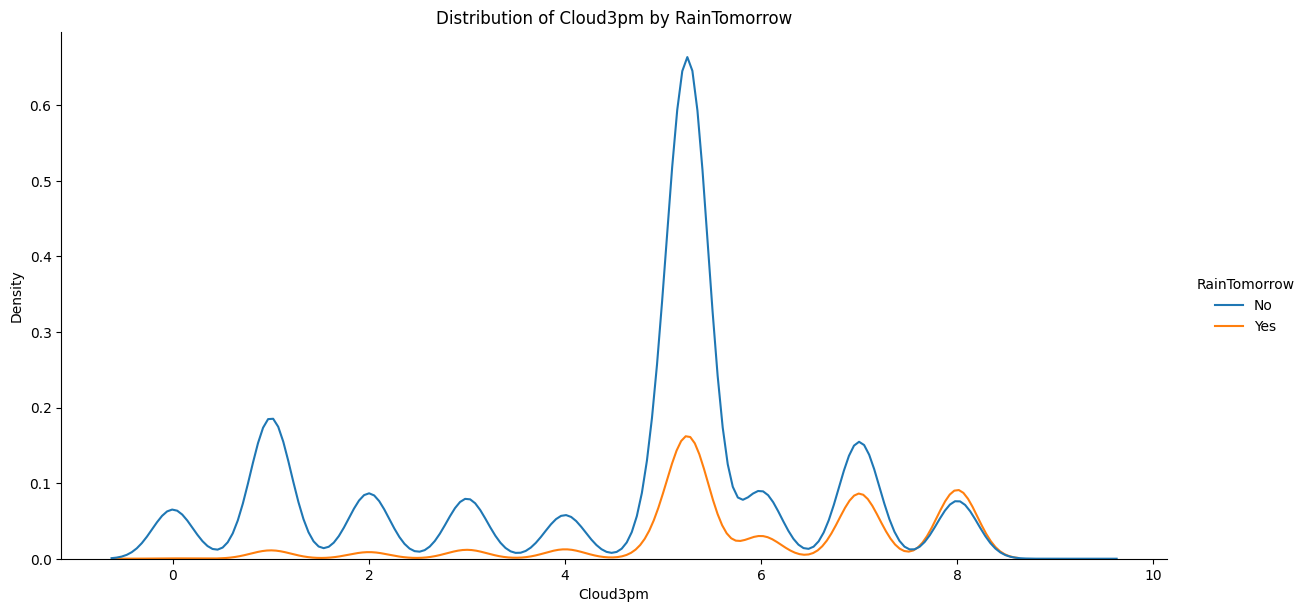

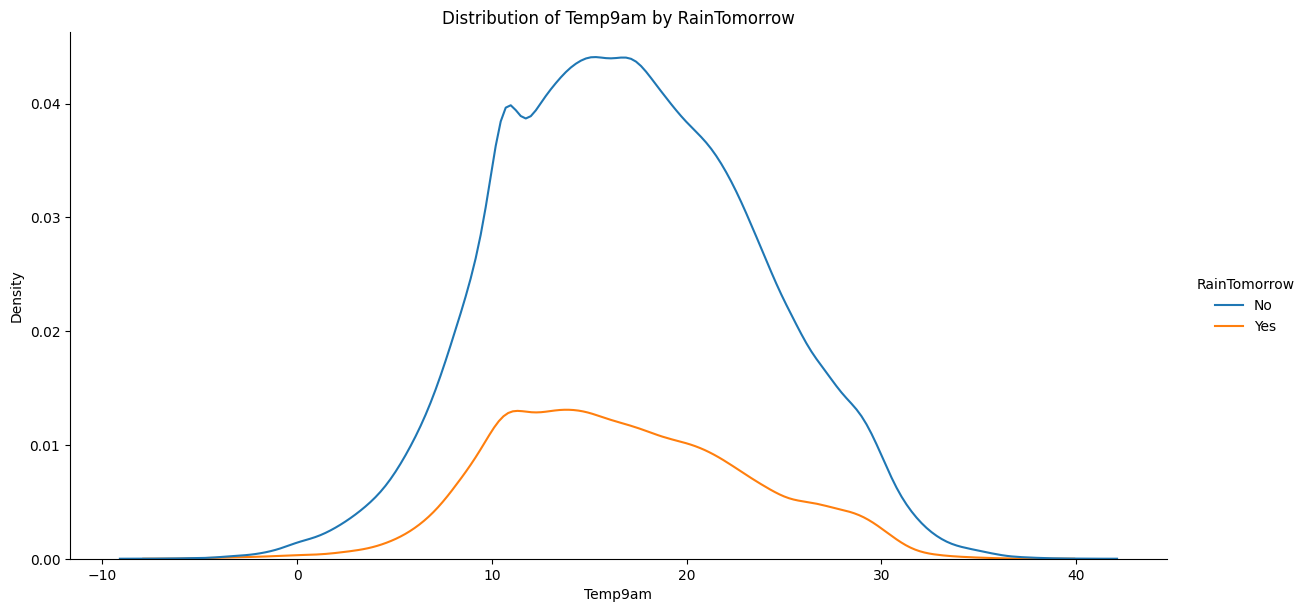

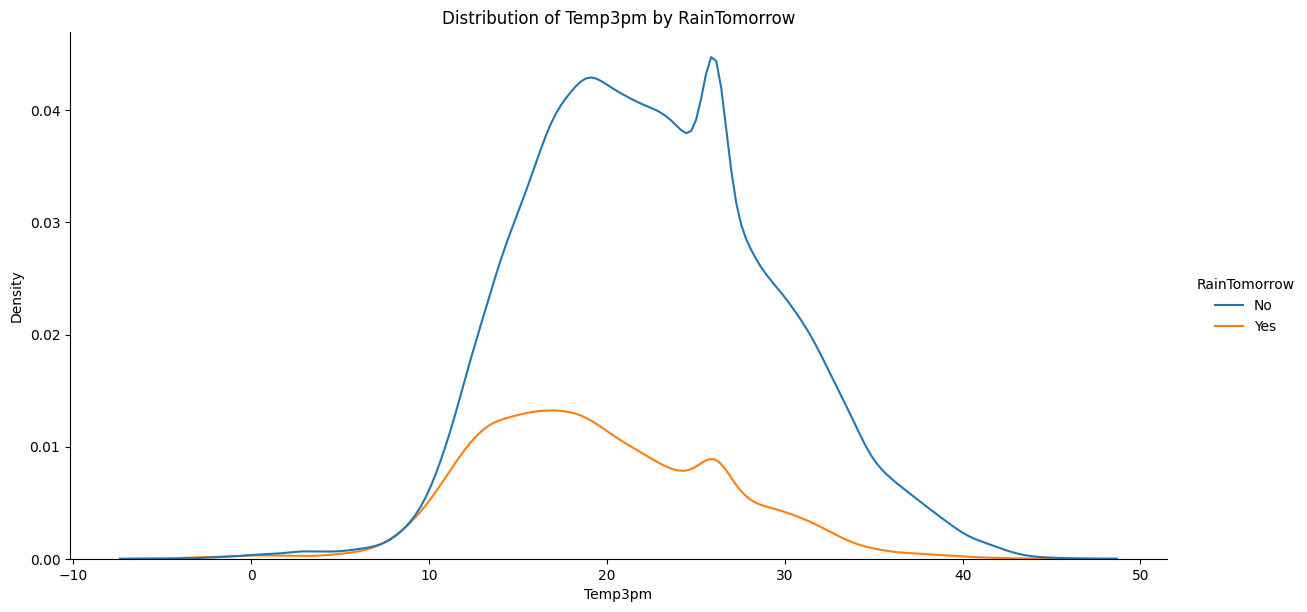

In [589]:
for col in col_to_modify:
    sns.displot(data=features, x=col, hue="RainTomorrow", kind="kde", height=6, aspect=2)
    plt.title(f'Distribution of {col} by RainTomorrow')
    plt.show()

In [590]:
columns_to_be_kept = []
for i in col_to_modify:
    if features[i].dtype == "float64":
        columns_to_be_kept.append(i)

In [591]:
columns_to_be_kept

['Avg_temp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [592]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  object 
 1   Rainfall       145460 non-null  float64
 2   Evaporation    145460 non-null  float64
 3   Sunshine       145460 non-null  float64
 4   WindGustDir    145460 non-null  object 
 5   WindGustSpeed  145460 non-null  float64
 6   WindDir9am     145460 non-null  object 
 7   WindDir3pm     145460 non-null  object 
 8   WindSpeed9am   145460 non-null  float64
 9   WindSpeed3pm   145460 non-null  float64
 10  Humidity9am    145460 non-null  float64
 11  Humidity3pm    145460 non-null  float64
 12  Pressure9am    145460 non-null  float64
 13  Pressure3pm    145460 non-null  float64
 14  Cloud9am       145460 non-null  float64
 15  Cloud3pm       145460 non-null  float64
 16  Temp9am        145460 non-null  float64
 17  Temp3pm        145460 non-nul

In [593]:
from scipy.stats import f_oneway

columns_to_be_kept_numerical = []

for i in columns_to_be_kept:
    a = list(features[i])  
    b = list(features["RainTomorrow"])  
    
    group_P1 = [value for value, group in zip(a, b) if group == 'No']
    group_P2 = [value for value, group in zip(a, b) if group == 'Yes']

    f_statistic, p_value = f_oneway(group_P1, group_P2)

    if p_value <= 0.05:
        columns_to_be_kept_numerical.append(i)

In [594]:
columns_to_be_kept_numerical

['Avg_temp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [595]:
for i in columns_to_be_kept:
    if(i not in columns_to_be_kept_numerical):
        print(i)

In [596]:
#all are imp..

In [597]:
for i in columns_to_be_kept_numerical:
    Q1 = features[i].quantile(0.25)
    Q3 = features[i].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
    features[i] = np.where(features[i] > upper_bound, upper_bound, features[i])
    features[i] = np.where(features[i] < lower_bound, lower_bound, features[i])

C:\Users\asus\AppData\Local\Temp\ipykernel_3224\2524434445.py:5: UserWarning: 
The palette list has fewer values (5) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)#boxenplot h


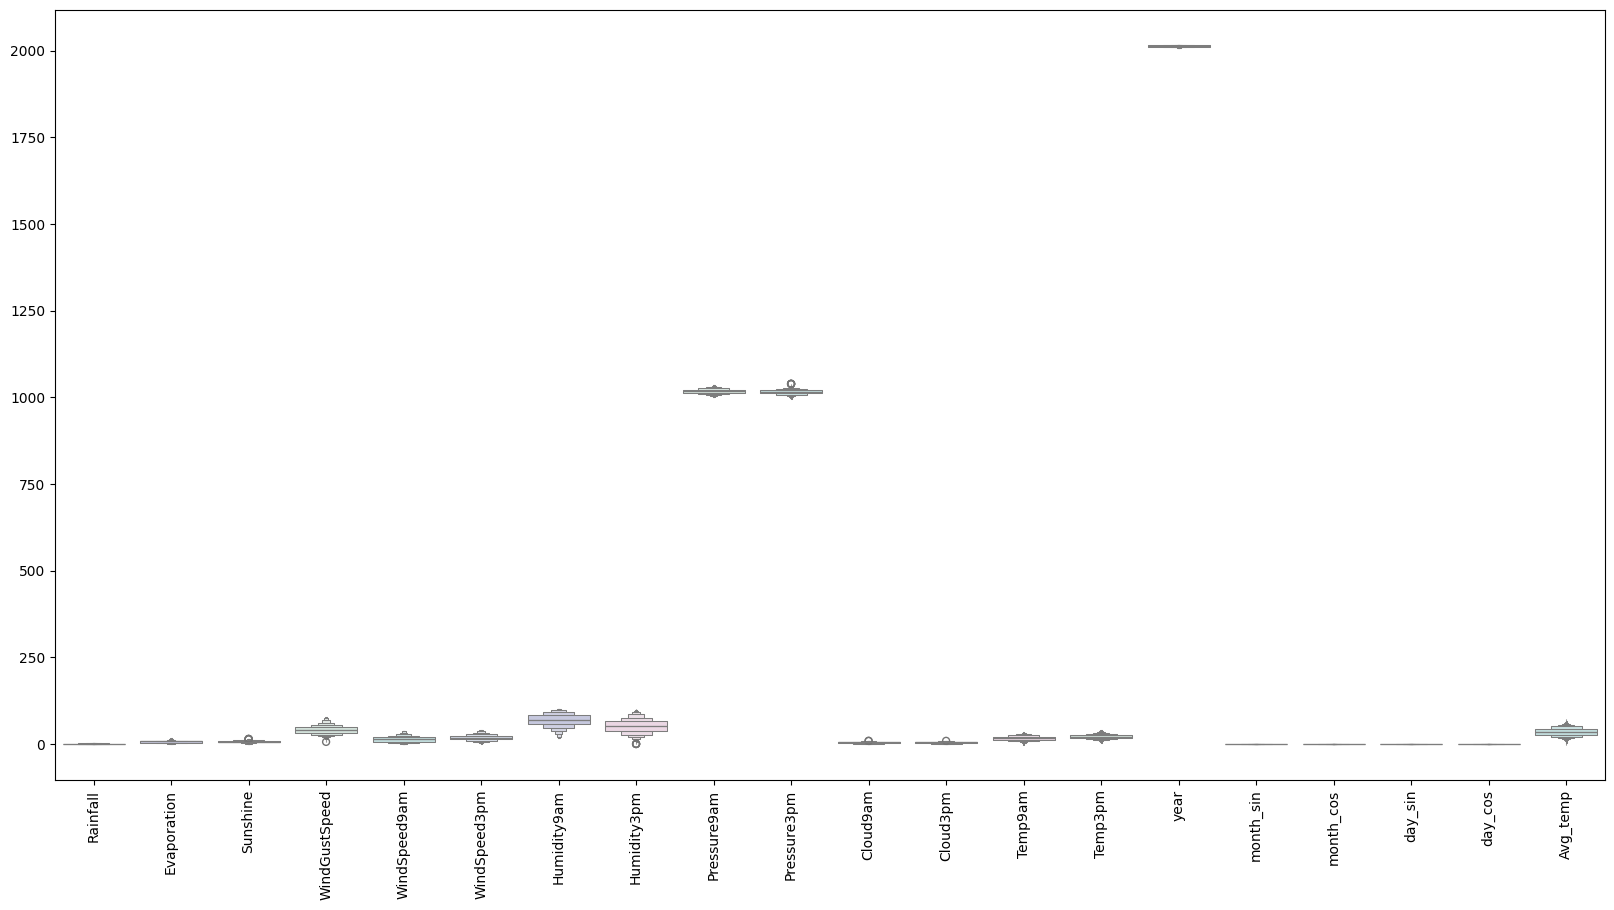

In [598]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)#boxenplot h 
plt.xticks(rotation=90)#taaki x label vertical dekhe
plt.show()

In [599]:
features.shape

(145460, 26)

In [600]:
features

,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Temp9am,Temp3pm,RainToday,year,month_sin,month_cos,day_sin,day_cos,Avg_temp,RainTomorrow
0,Albury,0.6,9.449517,4.965421,W,44.000000,W,WNW,20.0,24.0,...,16.9,21.8,No,2008,-2.449294e-16,1.0,0.201299,0.979530,36.300000,No
1,Albury,0.0,9.449517,4.965421,WNW,44.000000,NNW,WSW,4.0,22.0,...,17.2,24.3,No,2008,-2.449294e-16,1.0,0.394356,0.918958,32.500000,No
2,Albury,0.0,9.449517,4.965421,WSW,46.000000,W,WSW,19.0,26.0,...,21.0,23.2,No,2008,-2.449294e-16,1.0,0.571268,0.820763,38.600000,No
3,Albury,0.0,9.449517,4.965421,NE,24.000000,SE,E,11.0,9.0,...,18.1,26.5,No,2008,-2.449294e-16,1.0,0.724793,0.688967,37.200000,No
4,Albury,1.0,9.449517,4.965421,W,41.000000,ENE,NW,7.0,20.0,...,17.8,29.7,No,2008,-2.449294e-16,1.0,0.848644,0.528964,49.800000,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,0.0,9.449517,4.965421,E,31.000000,SE,ENE,13.0,11.0,...,10.1,22.4,No,2017,1.224647e-16,-1.0,-0.897805,-0.440394,26.200000,No
145456,Uluru,0.0,9.449517,4.965421,NNW,22.000000,SE,N,13.0,9.0,...,10.9,24.5,No,2017,1.224647e-16,-1.0,-0.968077,-0.250653,28.900000,No
145457,Uluru,0.0,9.449517,4.965421,N,37.000000,SE,WNW,9.0,9.0,...,12.5,26.1,No,2017,1.224647e-16,-1.0,-0.998717,-0.050649,32.300000,No
145458,Uluru,0.0,9.449517,4.965421,SE,28.000000,SSE,N,13.0,7.0,...,15.1,26.0,No,2017,1.224647e-16,-1.0,-0.988468,0.151428,34.800000,No


In [601]:
object_cols

Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday',
       'RainTomorrow'],
      dtype='object')

In [602]:
data=features

In [603]:
data["RainTomorrow"]

0         No
1         No
2         No
3         No
4         No
          ..
145455    No
145456    No
145457    No
145458    No
145459    No
Name: RainTomorrow, Length: 145460, dtype: object

In [604]:
data[object_cols]

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,Albury,W,W,WNW,No,No
1,Albury,WNW,NNW,WSW,No,No
2,Albury,WSW,W,WSW,No,No
3,Albury,NE,SE,E,No,No
4,Albury,W,ENE,NW,No,No
...,...,...,...,...,...,...
145455,Uluru,E,SE,ENE,No,No
145456,Uluru,NNW,SE,N,No,No
145457,Uluru,N,SE,WNW,No,No
145458,Uluru,SE,SSE,N,No,No


In [605]:
data.columns

Index(['Location', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
       'RainToday', 'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'Avg_temp', 'RainTomorrow'],
      dtype='object')

In [606]:
num_cols=[]
for i in data.columns:
    if(i not in object_cols):
        num_cols.append(i)

In [607]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
data["RainTomorrow"]=le.fit_transform(data["RainTomorrow"])

In [608]:
num_cols

['Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'year',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'Avg_temp']

In [609]:
object_cols=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [610]:
data[object_cols]

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
0,Albury,W,W,WNW,No
1,Albury,WNW,NNW,WSW,No
2,Albury,WSW,W,WSW,No
3,Albury,NE,SE,E,No
4,Albury,W,ENE,NW,No
...,...,...,...,...,...
145455,Uluru,E,SE,ENE,No
145456,Uluru,NNW,SE,N,No
145457,Uluru,N,SE,WNW,No
145458,Uluru,SE,SSE,N,No


In [611]:
data["Location"].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [612]:
data["WindGustDir"].unique()

array(['W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', 'ENE', 'SSE',
       'S', 'NW', 'SE', 'ESE', 'E', 'SSW'], dtype=object)

In [613]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
data["RainToday"]=le.fit_transform(data["RainToday"])


In [614]:
object_cols=["Location"	,"WindGustDir","WindDir9am"	,"WindDir3pm"]

In [615]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  object 
 1   Rainfall       145460 non-null  float64
 2   Evaporation    145460 non-null  float64
 3   Sunshine       145460 non-null  float64
 4   WindGustDir    145460 non-null  object 
 5   WindGustSpeed  145460 non-null  float64
 6   WindDir9am     145460 non-null  object 
 7   WindDir3pm     145460 non-null  object 
 8   WindSpeed9am   145460 non-null  float64
 9   WindSpeed3pm   145460 non-null  float64
 10  Humidity9am    145460 non-null  float64
 11  Humidity3pm    145460 non-null  float64
 12  Pressure9am    145460 non-null  float64
 13  Pressure3pm    145460 non-null  float64
 14  Cloud9am       145460 non-null  float64
 15  Cloud3pm       145460 non-null  float64
 16  Temp9am        145460 non-null  float64
 17  Temp3pm        145460 non-nul

In [625]:
data

,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Temp9am,Temp3pm,RainToday,year,month_sin,month_cos,day_sin,day_cos,Avg_temp,RainTomorrow
0,Albury,0.6,9.449517,4.965421,W,44.000000,W,WNW,20.0,24.0,...,16.9,21.8,0,2008,-2.449294e-16,1.0,0.201299,0.979530,36.300000,0
1,Albury,0.0,9.449517,4.965421,WNW,44.000000,NNW,WSW,4.0,22.0,...,17.2,24.3,0,2008,-2.449294e-16,1.0,0.394356,0.918958,32.500000,0
2,Albury,0.0,9.449517,4.965421,WSW,46.000000,W,WSW,19.0,26.0,...,21.0,23.2,0,2008,-2.449294e-16,1.0,0.571268,0.820763,38.600000,0
3,Albury,0.0,9.449517,4.965421,NE,24.000000,SE,E,11.0,9.0,...,18.1,26.5,0,2008,-2.449294e-16,1.0,0.724793,0.688967,37.200000,0
4,Albury,1.0,9.449517,4.965421,W,41.000000,ENE,NW,7.0,20.0,...,17.8,29.7,0,2008,-2.449294e-16,1.0,0.848644,0.528964,49.800000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,0.0,9.449517,4.965421,E,31.000000,SE,ENE,13.0,11.0,...,10.1,22.4,0,2017,1.224647e-16,-1.0,-0.897805,-0.440394,26.200000,0
145456,Uluru,0.0,9.449517,4.965421,NNW,22.000000,SE,N,13.0,9.0,...,10.9,24.5,0,2017,1.224647e-16,-1.0,-0.968077,-0.250653,28.900000,0
145457,Uluru,0.0,9.449517,4.965421,N,37.000000,SE,WNW,9.0,9.0,...,12.5,26.1,0,2017,1.224647e-16,-1.0,-0.998717,-0.050649,32.300000,0
145458,Uluru,0.0,9.449517,4.965421,SE,28.000000,SSE,N,13.0,7.0,...,15.1,26.0,0,2017,1.224647e-16,-1.0,-0.988468,0.151428,34.800000,0


In [626]:
target=data["RainTomorrow"]

In [627]:
num_cols

['Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'year',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'Avg_temp']

In [642]:
object_cols


['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [644]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), object_cols)
    ]
)

# Apply transformations
X = preprocessor.fit_transform(data).toarray()


In [645]:
X

array([[-0.017725  ,  0.68912485, -0.45356773, ...,  1.        ,
         0.        ,  0.        ],
       [-0.62127813,  0.68912485, -0.45356773, ...,  0.        ,
         1.        ,  0.        ],
       [-0.62127813,  0.68912485, -0.45356773, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.62127813,  0.68912485, -0.45356773, ...,  1.        ,
         0.        ,  0.        ],
       [-0.62127813,  0.68912485, -0.45356773, ...,  0.        ,
         0.        ,  0.        ],
       [-0.62127813,  0.68912485, -0.45356773, ...,  0.        ,
         0.        ,  0.        ]])

In [646]:
data

,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Temp9am,Temp3pm,RainToday,year,month_sin,month_cos,day_sin,day_cos,Avg_temp,RainTomorrow
0,Albury,0.6,9.449517,4.965421,W,44.000000,W,WNW,20.0,24.0,...,16.9,21.8,0,2008,-2.449294e-16,1.0,0.201299,0.979530,36.300000,0
1,Albury,0.0,9.449517,4.965421,WNW,44.000000,NNW,WSW,4.0,22.0,...,17.2,24.3,0,2008,-2.449294e-16,1.0,0.394356,0.918958,32.500000,0
2,Albury,0.0,9.449517,4.965421,WSW,46.000000,W,WSW,19.0,26.0,...,21.0,23.2,0,2008,-2.449294e-16,1.0,0.571268,0.820763,38.600000,0
3,Albury,0.0,9.449517,4.965421,NE,24.000000,SE,E,11.0,9.0,...,18.1,26.5,0,2008,-2.449294e-16,1.0,0.724793,0.688967,37.200000,0
4,Albury,1.0,9.449517,4.965421,W,41.000000,ENE,NW,7.0,20.0,...,17.8,29.7,0,2008,-2.449294e-16,1.0,0.848644,0.528964,49.800000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,0.0,9.449517,4.965421,E,31.000000,SE,ENE,13.0,11.0,...,10.1,22.4,0,2017,1.224647e-16,-1.0,-0.897805,-0.440394,26.200000,0
145456,Uluru,0.0,9.449517,4.965421,NNW,22.000000,SE,N,13.0,9.0,...,10.9,24.5,0,2017,1.224647e-16,-1.0,-0.968077,-0.250653,28.900000,0
145457,Uluru,0.0,9.449517,4.965421,N,37.000000,SE,WNW,9.0,9.0,...,12.5,26.1,0,2017,1.224647e-16,-1.0,-0.998717,-0.050649,32.300000,0
145458,Uluru,0.0,9.449517,4.965421,SE,28.000000,SSE,N,13.0,7.0,...,15.1,26.0,0,2017,1.224647e-16,-1.0,-0.988468,0.151428,34.800000,0


Looks Good. Up next is building artificial neural network.

In [647]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2, random_state = 2)

X.shape

(145460, 114)

In [648]:
X_train

array([[-0.62127813,  0.02072134,  1.27247951, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.59175003,  0.68912485, -0.45356773, ...,  0.        ,
         0.        ,  1.        ],
       [-0.42009376,  0.68912485, -0.45356773, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.8935266 , -0.33583709,  0.71192241, ...,  0.        ,
         0.        ,  1.        ],
       [-0.62127813, -0.33583709,  1.23950556, ...,  0.        ,
         1.        ,  0.        ],
       [-0.62127813,  1.14982307,  1.50329714, ...,  0.        ,
         0.        ,  0.        ]])

In [649]:
X_test

array([[-0.62127813,  0.25842697, -0.45356773, ...,  0.        ,
         0.        ,  0.        ],
       [-0.62127813,  0.68912485, -0.45356773, ...,  0.        ,
         0.        ,  0.        ],
       [-0.62127813,  1.09039666,  0.28326109, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.42009376, -1.82149726, -0.11242628, ...,  0.        ,
         0.        ,  0.        ],
       [-0.62127813,  0.68912485, -0.45356773, ...,  0.        ,
         0.        ,  0.        ],
       [-0.62127813,  0.555559  ,  0.61300057, ...,  0.        ,
         0.        ,  0.        ]])

In [650]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 128, kernel_initializer = tf.keras.initializers.GlorotUniform(), activation = 'relu', input_dim = 114))
model.add(BatchNormalization()) 
model.add(Dense(units = 128, kernel_initializer = tf.keras.initializers.GlorotUniform(), activation = 'relu'))
model.add(Dense(units = 64, kernel_initializer = tf.keras.initializers.GlorotUniform(), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 32, kernel_initializer = tf.keras.initializers.GlorotUniform(), activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 8, kernel_initializer = tf.keras.initializers.GlorotUniform(), activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = tf.keras.initializers.GlorotUniform(), activation = 'sigmoid'))
opt = Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
2910/2910 [==============================] - 11s 4ms/step - loss: 0.4232 - accuracy: 0.8149 - val_loss: 0.3531 - val_accuracy: 0.8485
Epoch 2/150
2910/2910 [==============================] - 11s 4ms/step - loss: 0.3850 - accuracy: 0.8315 - val_loss: 0.3463 - val_accuracy: 0.8505
Epoch 3/150
2910/2910 [==============================] - 10s 4ms/step - loss: 0.3749 - accuracy: 0.8373 - val_loss: 0.3373 - val_accuracy: 0.8560
Epoch 4/150
2910/2910 [==============================] - 10s 4ms/step - loss: 0.3657 - accuracy: 0.8397 - val_loss: 0.3342 - val_accuracy: 0.8536
Epoch 5/150
2910/2910 [==============================] - 10s 4ms/step - loss: 0.3603 - accuracy: 0.8426 - val_loss: 0.3366 - val_accuracy: 0.8497
Epoch 6/150
2910/2910 [==============================] - 11s 4ms/step - loss: 0.3540 - accuracy: 0.8456 - val_loss: 0.3296 - val_accuracy: 0.8594
Epoch 7/150
2910/2910 [==============================] - 10s 4ms/step - loss: 0.3500 - accuracy: 0.8465 - val_loss: 0.3308 -

Plotting training and validation loss over epochs

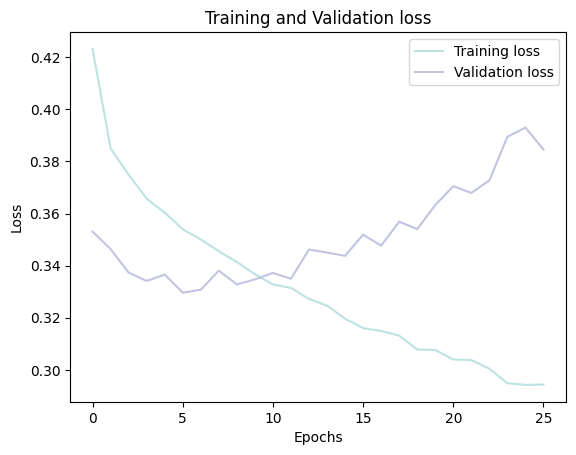

In [651]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

Plotting training and validation accuracy over epochs

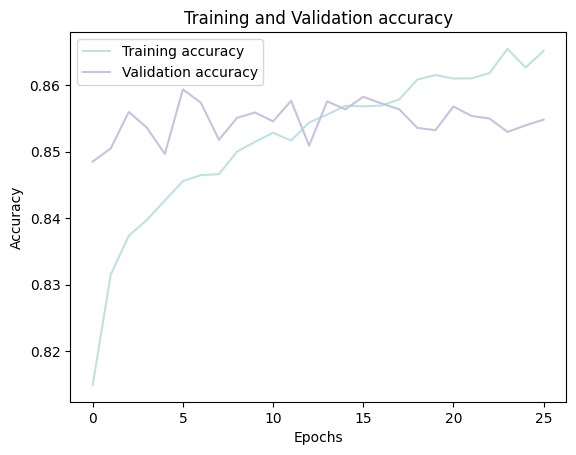

In [652]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [653]:
# Predicting the test set results
y_pred = model.predict(X_test)

y_pred

910/910 [==============================] - 1s 937us/step


array([[0.03843446],
       [0.0056659 ],
       [0.20925471],
       ...,
       [0.05679681],
       [0.1258659 ],
       [0.16394828]], dtype=float32)

In [654]:
y_pred[25503]

array([0.4830339], dtype=float32)

In [655]:
y_pred=np.where(y_pred>=0.5,1,0)

In [656]:
y_pred[25503]

array([0])

In [657]:
y_test

142958    0
124243    0
120094    0
7702      0
27268     0
         ..
118322    0
63632     0
101743    0
99210     0
86655     0
Name: RainTomorrow, Length: 29092, dtype: int32

<Axes: >

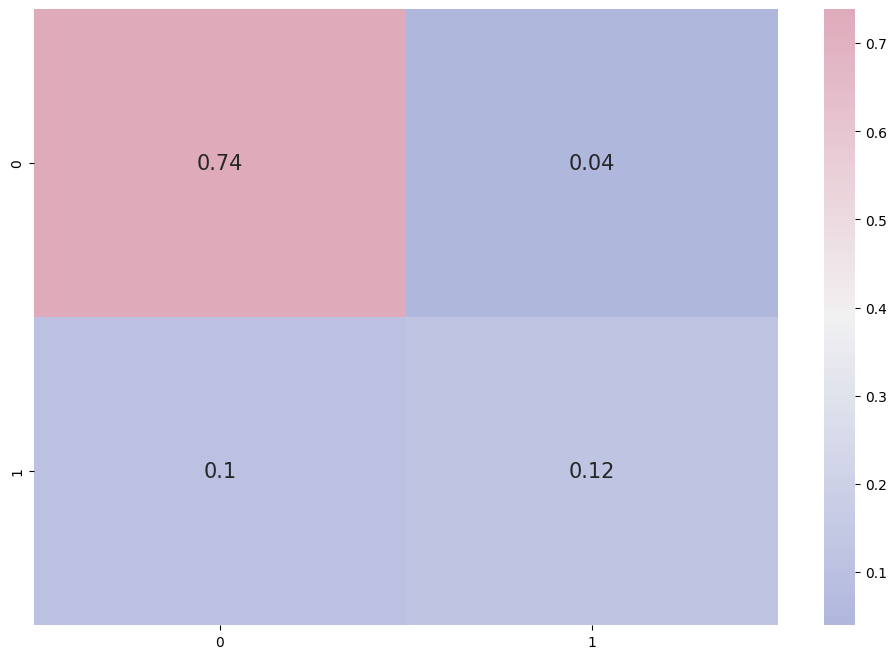

In [658]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [659]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22634
           1       0.75      0.53      0.62      6458

    accuracy                           0.86     29092
   macro avg       0.81      0.74      0.77     29092
weighted avg       0.85      0.86      0.85     29092



In [660]:
import pickle

In [661]:
with open ("data.pkl","wb") as f1:
    pickle.dump(data,f1)

In [662]:
model.save("modelrain")#for keras

INFO:tensorflow:Assets written to: modelrain\assets


In [663]:
model.save("modelrain_final.keras")#for keras

In [664]:
with open ("preprocessor.pkl","wb") as f1:
    pickle.dump(preprocessor,f1)

In [666]:
num_cols

['Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'year',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'Avg_temp']

In [667]:
object_cols

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [671]:
#'Rainfall','Evaporation','Sunshine','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Cloud9am','Cloud3pm','Temp9am','Temp3pm','year',
#Avg_temp''Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday',"day"]
#input lena h
#phir jo order m cols data h h us order m dataframe bnana
#phir preprocessor lgana then predict

In [672]:
data

,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Temp9am,Temp3pm,RainToday,year,month_sin,month_cos,day_sin,day_cos,Avg_temp,RainTomorrow
0,Albury,0.6,9.449517,4.965421,W,44.000000,W,WNW,20.0,24.0,...,16.9,21.8,0,2008,-2.449294e-16,1.0,0.201299,0.979530,36.300000,0
1,Albury,0.0,9.449517,4.965421,WNW,44.000000,NNW,WSW,4.0,22.0,...,17.2,24.3,0,2008,-2.449294e-16,1.0,0.394356,0.918958,32.500000,0
2,Albury,0.0,9.449517,4.965421,WSW,46.000000,W,WSW,19.0,26.0,...,21.0,23.2,0,2008,-2.449294e-16,1.0,0.571268,0.820763,38.600000,0
3,Albury,0.0,9.449517,4.965421,NE,24.000000,SE,E,11.0,9.0,...,18.1,26.5,0,2008,-2.449294e-16,1.0,0.724793,0.688967,37.200000,0
4,Albury,1.0,9.449517,4.965421,W,41.000000,ENE,NW,7.0,20.0,...,17.8,29.7,0,2008,-2.449294e-16,1.0,0.848644,0.528964,49.800000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,0.0,9.449517,4.965421,E,31.000000,SE,ENE,13.0,11.0,...,10.1,22.4,0,2017,1.224647e-16,-1.0,-0.897805,-0.440394,26.200000,0
145456,Uluru,0.0,9.449517,4.965421,NNW,22.000000,SE,N,13.0,9.0,...,10.9,24.5,0,2017,1.224647e-16,-1.0,-0.968077,-0.250653,28.900000,0
145457,Uluru,0.0,9.449517,4.965421,N,37.000000,SE,WNW,9.0,9.0,...,12.5,26.1,0,2017,1.224647e-16,-1.0,-0.998717,-0.050649,32.300000,0
145458,Uluru,0.0,9.449517,4.965421,SE,28.000000,SSE,N,13.0,7.0,...,15.1,26.0,0,2017,1.224647e-16,-1.0,-0.988468,0.151428,34.800000,0


In [674]:
data.columns

Index(['Location', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
       'RainToday', 'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'Avg_temp', 'RainTomorrow'],
      dtype='object')